In [ ]:
!pip install slimevolleygym dm-sonnet trfl wandb

     |████████████████████████████████| 254 kB 8.4 MB/s 
     |████████████████████████████████| 104 kB 50.3 MB/s 
     |████████████████████████████████| 1.7 MB 42.0 MB/s 
     |████████████████████████████████| 139 kB 63.9 MB/s 
     |████████████████████████████████| 180 kB 60.9 MB/s 
     |████████████████████████████████| 97 kB 5.3 MB/s 
     |████████████████████████████████| 63 kB 1.4 MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6502 sha256=2a686d50ab9eb306f43bc37de11cc377636cf23a0994c4c74098f29066eca460
  Stored in directory: /root/.cache/pip/wheels/50/ca/fa/8fca8d246e64f19488d07567547ddec8eb084e8c0d7a59226a
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=404dca8a379e8dd66ba0721b2e90bef67607f6f6f1d18a278906849eb1e0d916
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built subprocess32 pathtools


In [ ]:
import gym
import slimevolleygym
import numpy as np
import tensorflow as tf
from typing import NamedTuple
import sonnet as snt
import trfl
import copy
import wandb
import matplotlib.pyplot as plt

In [ ]:
ACTION_LOOKUP = [
  [0, 0, 0], # NOOP
  [1, 0, 0], # LEFT (forward)
  [1, 0, 1], # UPLEFT (forward jump)
  [0, 0, 1], # UP (jump)
  [0, 1, 1], # UPRIGHT (backward jump)
  [0, 1, 0]  # RIGHT (backward)
] 

In [ ]:

# def random_policy(obs):
#   action_id = np.random.randint(6)
#   return ACTION_LOOKUP[action_id], action_id


In [ ]:
# def run_one_episode(policy, env):
#   obs = env.reset()
#   done = False
#   total_reward = 0

#   while not done:
#     action, action_id = policy(obs)
#     obs, reward, done, info = env.step(action)
#     total_reward += reward
#     # env.render()

#   return total_reward

In [ ]:
env = gym.make("SlimeVolley-v0")


In [ ]:
# returns = []
# for episode in range(100):
#   reward = run_one_episode(random_policy, env)
#   returns.append(reward)
  
# print("av. returns = ", np.mean(returns))



av. returns =  -4.82


In [ ]:
class Batch(NamedTuple):
    """Container for a batch of experience tuples."""
    observation: np.array
    next_observation: np.array
    reward: np.array
    action: np.array
    done: np.array


class TransitionBuffer:

    def __init__(
        self,
        observation_dim,
        buffer_size=5000,  # Num episodes
        batch_size=32
    ):
        self.observation_dim = observation_dim
        self.buffer_size = buffer_size
        self.batch_size = batch_size

        observation_buffer_shape = (buffer_size, observation_dim)
        self.observation_buffer = np.zeros(observation_buffer_shape, dtype='float32')
        self.next_observation_buffer = np.zeros(observation_buffer_shape, dtype='float32')

        action_buffer_shape = (buffer_size, )
        self.action_buffer = np.zeros(action_buffer_shape, dtype='int32')
        self.reward_buffer = np.zeros(action_buffer_shape, dtype='float32')
        self.dones_buffer = np.zeros(action_buffer_shape, dtype='float32')

        self.counter = 0

    def can_sample_batch(self):
        return self.counter >= self.batch_size  # Cannot sample more than the batch size

    def add(
        self,
        batch: Batch,
    ):
        idx = self.counter % self.buffer_size  # FIFO

        self.observation_buffer[idx] = batch.observation
        self.next_observation_buffer[idx] = batch.next_observation
        self.action_buffer[idx] = batch.action
        self.reward_buffer[idx] = batch.reward
        self.dones_buffer[idx] = batch.done

        self.counter += 1

    def sample(self):
        assert self.can_sample_batch()

        max_idx = min(self.counter, self.buffer_size)
        idxs = np.random.choice(max_idx, size=self.batch_size, replace=True)

        observation_batch = tf.convert_to_tensor(self.observation_buffer[idxs])
        next_observation_batch = tf.convert_to_tensor(self.next_observation_buffer[idxs])
        action_batch = tf.convert_to_tensor(self.action_buffer[idxs])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[idxs])
        dones_batch = tf.convert_to_tensor(self.dones_buffer[idxs])

        batch = Batch(
            observation=observation_batch,
            next_observation=next_observation_batch,
            action=action_batch,
            reward=reward_batch,
            done=dones_batch,
        )

        return batch

In [ ]:
# def run_one_episode(policy, env, replay):
#   obs = env.reset()
#   done = False
#   total_reward = 0

#   while not done:
#     action, action_id = policy(obs)
#     next_obs, reward, done, info = env.step(action)
#     batch = Batch(observation = obs, next_observation = next_obs, action = action_id, reward = reward, done = done)
#     replay.add(batch)
#     total_reward += reward
#     # env.render()
#     obs = next_obs

#   return total_reward

In [ ]:
# obs = env.reset()
# print(obs.shape)


(12,)


In [ ]:
# replay = TransitionBuffer(12)

In [ ]:
# run_one_episode(random_policy, env, replay)

-5

In [ ]:
# returns = []
# for episode in range(100):
#   reward = run_one_episode(random_policy, env, replay)
#   returns.append(reward)
  
# print("av. returns = ", np.mean(returns))

av. returns =  -4.86


In [ ]:
# batch = replay.sample()

In [ ]:
class Counter:

    def __init__(self):
        self.value = 0

In [ ]:
class Actor:
  def __init__(self, num_actions, q_net, replay, counter, eps_decay = 0.999999, eps_min=0.05):
    self.eps_decay = eps_decay
    self.eps_min = eps_min
    self.eps = 1
    self.num_actions = num_actions
    self.q_net = q_net
    self.replay = replay
    self.ctr = counter

  def observe(self, obs, act, rew, next_obs, done):
    batch = Batch(
      observation=self._concat_extras(obs),
      next_observation=self._concat_extras(next_obs),
      reward=rew,
      action=act,
      done=done
    )
    
    self.replay.add(batch)

  def _concat_extras(self, obs):
    eps = [self.eps]
    learn_step = [self.ctr.value / 1_000_000]
    new_obs = np.concatenate([eps, learn_step, obs])
    return new_obs
    

  def policy(self, obs):
    if np.random.random() < self.eps:
      action_id = np.random.randint(self.num_actions)
    else: 
      obs = self._concat_extras(obs)
      obs = tf.convert_to_tensor(obs, dtype = 'float32')
      obs = tf.reshape(obs, (1,-1))
      q_values = self.q_net(obs)
      action_id = tf.argmax(q_values, axis = -1).numpy()[0]
    action = ACTION_LOOKUP[action_id]
    self.decrement_epsilon()
    return action, action_id

  def decrement_epsilon(self):
    self.eps = max(self.eps_min, self.eps_decay*self.eps)


In [ ]:
# q_net = snt.nets.MLP((64, 6))
# actor = Actor(6, q_net)

In [ ]:
def run_one_episode(actor, env, replay):
  obs = env.reset()
  done = False
  total_reward = 0

  while not done:
    action, action_id = actor.policy(obs)
    #print(actor.eps)
    next_obs, reward, done, info = env.step(action)
    batch = Batch(observation = obs, next_observation = next_obs, action = action_id, reward = reward, done = done)
    replay.add(batch)
    total_reward += reward
    # env.render()
    obs = next_obs

  return total_reward

In [ ]:
run_one_episode(actor, env, replay)

-5

In [ ]:
class Learner:
  def __init__(self, q_net, target_q_net, counter, lr = 5e-4, discount = 0.99, target_update_period = 200):
    self.q_net = q_net
    self.target_q_net = target_q_net
    self.lr = lr
    self.discount = discount
    self.target_update_period = target_update_period
    self.optimiser = snt.optimizers.Adam(lr)
    self.counter = counter


  @tf.function
  def learn(self, batch):
    obs = batch.observation
    next_obs = batch.next_observation
    action_id = batch.action
    reward = batch.reward
    done = batch.done

    with tf.GradientTape() as tape:

      q_values = self.q_net(obs)  #[B, Act]
      selected_q_value = trfl.batched_index(q_values, action_id) #[B]

      # Standard Q-learning
      next_q_values = self.target_q_net(next_obs)
      max_next_q_value = tf.reduce_max(next_q_values, axis=-1)

      # Bellman target
      target = reward + self.discount * (1 - done) * max_next_q_value

      # Temporal difference
      td_error = selected_q_value - target

      # Mean-squared error
      loss = tf.reduce_mean(td_error ** 2)


    variables = self.q_net.trainable_variables #from sonnet
    gradients = tape.gradient(loss, variables)
    self.optimiser.apply(updates=gradients, parameters=variables)

    return loss

  def update_target_network(self):
        """Update target network."""
        if self.counter.value % self.target_update_period == 0:
            online_variables = (*self.q_net.variables,)
            target_variables = (*self.target_q_net.variables,)

            for src, dest in zip(online_variables, target_variables):
                dest.assign(src)

        self.counter.value += 1

In [ ]:

target_q_net = copy.deepcopy(q_net)
learner = Learner(q_net, target_q_net)


In [ ]:
batch = replay.sample()
learner.learn(batch)

<tf.Tensor: shape=(), dtype=float32, numpy=0.07789205>

In [ ]:
def train(learner, actor, replay_buffer, env, num_episodes = 10000, learner_steps_per_episode = 100):

  episode_returns = []

  for episode in range(num_episodes):

    episode_return = run_one_episode(actor, env, replay_buffer)
    episode_returns.append(episode_return)

    losses = []
    for learner_step in range(learner_steps_per_episode):
      batch = replay.sample()
      loss = learner.learn(batch)
      losses.append(loss)
    
    if episode % 10 == 0:
      print(f"episode: {episode}  episode_return: {episode_return}  smoothed episode return: {np.mean(episode_returns[-50:])}  epsilon: {actor.eps} loss: {np.mean(losses)}")


In [ ]:
LEARN_EVERY = 8

q_net = snt.nets.MLP((128,128, 6))
target_q_net = copy.deepcopy(q_net)

actor = Actor(6, target_q_net, replay, Counter())
learner = Learner(q_net, target_q_net, Counter())
replay = TransitionBuffer(12, batch_size=256, buffer_size=1000000)

env = gym.make("SlimeVolley-v0")

t = 0
returns = []
lens = []
losses = []
for e in range(10_000):
    done = False
    ep_return = 0
    obs = env.reset()
    ep_len = 0
    while not done:

        action, action_id = actor.policy(obs)

        next_obs, reward, done, _ = env.step(action)

        batch = Batch(
            observation=obs,
            next_observation=next_obs,
            reward=reward,
            done=done,
            action=action_id,
        )

        replay.add(batch)

        if t % LEARN_EVERY == 0 and replay.can_sample_batch():
            batch = replay.sample()
            loss = learner.learn(batch)
            learner.update_target_network()
            losses.append(loss)


        obs = next_obs
        ep_return += reward
        t += 1
        ep_len += 1

    returns.append(ep_return)
    lens.append(ep_len)

    if e % 100 == 0:
        print(f"ep: {e}  t: {t} ep_return: {ep_return}  smoothed ep_return: {np.mean(returns[-100:])}   ep_len: {ep_len}   smoothed ep_len: {np.mean(lens[-100:])}  eps: {actor.eps} loss: {np.mean(losses[-10:])} ")

NameError: ignored

In [ ]:
LEARN_EVERY = 8

q_net1 = snt.nets.MLP((64,64, 6))
target_q_net1 = copy.deepcopy(q_net1)
counter1 = Counter()
replay1 = TransitionBuffer(14, batch_size=256, buffer_size=10000)
actor1 = Actor(6, target_q_net1, replay1, counter1, eps_decay=0.999999)
learner1 = Learner(q_net1, target_q_net1, counter1)

q_net2 = snt.nets.MLP((64,64, 6))
target_q_net2 = copy.deepcopy(q_net2)
replay2 = TransitionBuffer(14, batch_size=256, buffer_size=10000)
counter2 = Counter()
actor2 = Actor(6, target_q_net2, replay2, counter2, eps_decay=0.999999)
learner2 = Learner(q_net2, target_q_net2, counter2)


env = gym.make("SlimeVolley-v0")

#wandb.init(project = "MultiSlime", name = "MultiSlime")

t = 0
returns = []
lens = []
losses = []
for e in range(5000):
    done = False
    ep_return = 0
    obs1 = env.reset()
    obs2 = obs1
    ep_len = 0
    while not done:

        action1, action_id1 = actor1.policy(obs1)
        action2, action_id2 = actor2.policy(obs2)

        next_obs1, reward, done, info = env.step(action1, action2)
        next_obs2 = info['otherObs']

        actor1.observe(obs=obs1, act=action_id1, rew=min(reward, -reward), next_obs=next_obs1, done=done)

        actor2.observe(obs=obs2, act=action_id2, rew=min(reward, -reward), next_obs=next_obs2, done=done)

        if t % LEARN_EVERY == 0 and replay1.can_sample_batch() and replay2.can_sample_batch():
            batch1 = replay1.sample()
            batch2 = replay2.sample()

            loss = learner1.learn(batch1)
            loss = learner2.learn(batch2)

            learner1.update_target_network()
            learner2.update_target_network()

            losses.append(loss)


        obs1 = next_obs1
        obs2 = next_obs2

        ep_return += reward
        t += 1
        ep_len += 1

    returns.append(ep_return)
    lens.append(ep_len)
    #wandb.log({'reward':np.mean(returns[-100:]), 'lengths': ep_len}, step = e)
    if e % 25 == 0:
        print(f"ep: {e}  t: {t} ep_return: {ep_return}  smoothed ep_return: {np.mean(returns[-100:])}   ep_len: {ep_len}   smoothed ep_len: {np.mean(lens[-100:])}  eps: {actor1.eps} loss: {np.mean(losses[-10:])} learn steps: {learner1.counter.value}")

ep: 0  t: 521 ep_return: 4  smoothed ep_return: 4.0   ep_len: 521   smoothed ep_len: 521.0  eps: 0.9994791354365526 loss: 0.0371665395796299 learn steps: 34
ep: 25  t: 16833 ep_return: 5  smoothed ep_return: 0.038461538461538464   ep_len: 391   smoothed ep_len: 647.4230769230769  eps: 0.9833078750639589 loss: 0.014271475374698639 learn steps: 2073
ep: 50  t: 32873 ep_return: -1  smoothed ep_return: -0.47058823529411764   ep_len: 692   smoothed ep_len: 644.5686274509804  eps: 0.9676614288832533 loss: 0.015850482508540154 learn steps: 4078
ep: 75  t: 47989 ep_return: -4  smoothed ep_return: -0.10526315789473684   ep_len: 538   smoothed ep_len: 631.4342105263158  eps: 0.9531442487352768 loss: 0.01636453904211521 learn steps: 5967
ep: 100  t: 63198 ep_return: -2  smoothed ep_return: -0.07   ep_len: 694   smoothed ep_len: 626.77  eps: 0.9387575516197771 loss: 0.0200545284897089 learn steps: 7868
ep: 125  t: 79204 ep_return: -2  smoothed ep_return: 0.08   ep_len: 607   smoothed ep_len: 623.7

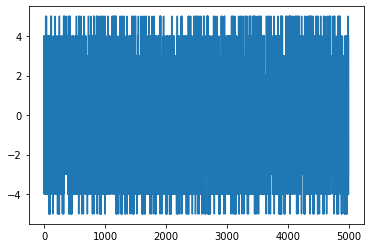

In [ ]:
plt.plot(returns)
plt.show()

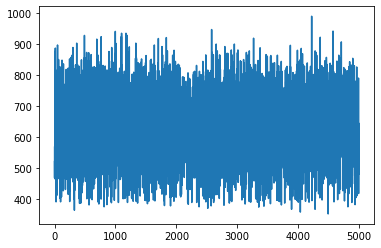

In [ ]:
  N = len(returns)
  running_avg_returns = np.empty(N)
  for t in range(N):
    running_avg_returns[t] = np.mean(returns[max(0, t-20):(t+1)])

In [ ]:
  N = len(lens)
  running_avg_lens = np.empty(N)
  for t in range(N):
    running_avg_lens[t] = np.mean(lens[max(0, t-20):(t+1)])

In [ ]:
np.savetxt("multi_slime_av_ret.csv", running_avg_returns, delimiter = ',')
np.savetxt("multi_slime_ret.csv", returns, delimiter = ',')
np.savetxt("multi_slime_av_len.csv", running_avg_lens, delimiter = ',')
np.savetxt("multi_slime_len.csv", lens, delimiter = ',')